- Find the number of people thta re pure specialist versus the people that have different occupations
- Show if the association is random or not

In [1]:
import pandas as pd
import sys
import os
import sqlite3
from dotenv import load_dotenv

In [2]:
sys.path.append('../')
sys.path.append('../src')

In [3]:
# Load the environment variables from the .env file
dotenv_path = os.path.join('../', '.env')
load_dotenv(dotenv_path)

True

In [4]:
conn_full_db = sqlite3.connect(os.getenv("FULL_DB_PATH"))
conn = sqlite3.connect("../database.db")

In [5]:
df_occupation = pd.read_sql("SELECT * FROM individual_id_cleaned_occupations", conn)

In [6]:
df_occupation_count = df_occupation.groupby('wikidata_id')['meta_occupation'].count().rename('count_occupation').reset_index()
df_occupation_count = df_occupation_count.sort_values('count_occupation', ascending=False)

Mean of occupation per individual

In [7]:
df_occupation_count.count_occupation.mean()

1.416003616636528

Number of specialist before 1600

In [17]:
df_temporal = pd.read_sql("SELECT * FROM temporal_data", conn)
df_temporal = df_temporal[['wikidata_id', 'birthyear']].drop_duplicates()
df_temporal = df_temporal[df_temporal['birthyear']<=1600]

In [23]:
df_occupation_count_temporal = pd.merge(df_occupation_count, df_temporal, on = 'wikidata_id')
len(df_occupation_count_temporal[df_occupation_count_temporal['count_occupation']==1])/len(df_occupation_count_temporal)

0.5741733690795353

Number of pure specialist

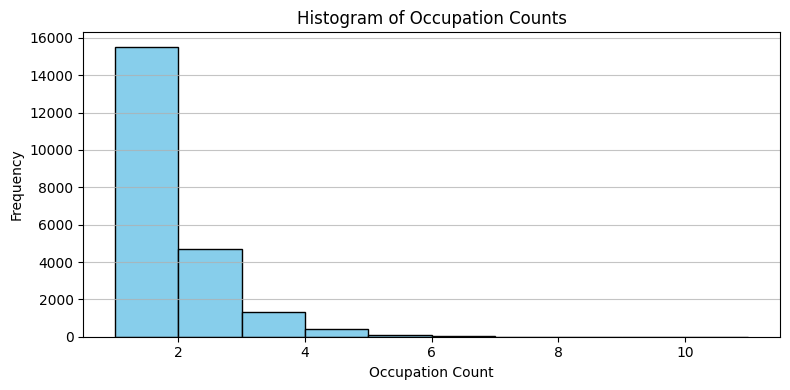

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Sort the DataFrame by count in descending order for a better visualization
df_sorted = df_occupation_count.sort_values(by='count_occupation', ascending=False)
# Create a histogram using Matplotlib
plt.figure(figsize=(8, 4))
plt.hist(df_sorted['count_occupation'], bins=10, color='skyblue', edgecolor='black')
plt.xlabel('Occupation Count')
plt.ylabel('Frequency')
plt.title('Histogram of Occupation Counts')
plt.grid(axis='y', alpha=0.75)

# Display the plot
plt.tight_layout()
plt.show()

Calculate the likelihood ratio and compare the chances of a mathematician being a philosopher versus a botanist. 

In [9]:
individual_more_than_1 = list(set(df_sorted.wikidata_id))

compute co-occurence and the likelyhood of being mathematician and botanist

Only get individuals with more than 1 occupation

In [10]:
df_occupation_more = df_occupation[df_occupation['wikidata_id'].isin(individual_more_than_1)]
import polars as pl
matrix = df_occupation_more.copy()
matrix.columns = ['source', 'target']
matrix['weight'] = 1
matrix = pl.from_pandas(matrix)
matrix = matrix.pivot(index="source", columns="target", values="weight")
matrix = matrix.fill_null(0)
matrix = matrix.to_pandas()
matrix = matrix.set_index("source")
cooc = matrix.T.dot(matrix)

co_occurrence = cooc.unstack().reset_index()
co_occurrence.columns = ["source", "target", "weight"]
co_occurrence = co_occurrence[co_occurrence["source"] != co_occurrence["target"]].reset_index(drop=True)
co_occurrence = co_occurrence[co_occurrence['weight']>0]
co_occurrence['likelihood'] = co_occurrence['weight']/len(set(df_occupation.wikidata_id))*100
co_occurrence = co_occurrence.sort_values('likelihood', ascending=False)

Make a test to show that the association between occupaiton (the co-occupation pattern) are not random.

In other words, the null hypothesis is the following:

occupation have all the same chances to cluster together.

In [11]:
from scipy.stats import chi2_contingency
chi2, p, _, _ = chi2_contingency(cooc)

In [12]:
chi2

415609.244025762